In [1]:
import pandas as pd
import random
import math
import operator
import numpy as np
import scipy as sc
from collections import Counter
from IPython.display import display, HTML


In [2]:
# statsmodels
import statsmodels.api as sm
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
#import statsmodels.formula.api as smf
#from statsmodels.stats.outliers_influence import variance_inflation_factor    

# Scikit-learn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

/Users/ando/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns

%matplotlib inline
plt.style.use('smandry')

In [16]:
class ModelStat(object):
    """
    Calculate model statistics:
    
    Example:
    
    >>> linreg = linear_model.LinearRegression()
    >>> linreg_stat = ModelStat(linreg, advertising[['TV']], advertising.Sales)
    >>> display(linreg_stat.results)
    """
    def __init__(self, model, X, y, fit=False, linear=True, cols=None, hypothesis=0):
        if fit:
            model.fit(X,y)
        self.model = model
        self.y = y
        self.nobs = X.shape[0]
        self.npred = X.shape[1]
        self.pred = model.predict(X)
        if isinstance(X, pd.DataFrame):
            newX = np.hstack((np.ones(self.nobs).reshape(-1,1), X.values))
            cols = ['Intercept']+list(X.columns)
            rankX = np.linalg.matrix_rank(X.values)
        else:
            newX = np.hstack((np.ones(self.nobs).reshape(-1,1), X))
            rankX = np.linalg.matrix_rank(X)
        self.dof = ModelStat.dof(X)
        self.RSS = ModelStat.rss(self.y, self.pred)
        self.MSE = ModelStat.mean_squared_error(self.y, self.pred, dof=self.dof)
        self.TSS = ModelStat.tss(self.y)
        self.rsquare = ModelStat.rsquare(self.y, self.pred)
        self.rsquare_adj = ModelStat.rsquare_adj(X, self.y, self.pred)
        if linear:
            self.params = np.append(model.intercept_,model.coef_)
            self.cov_params = ModelStat.cov_matrix(newX)
            variance = self.MSE * (self.cov_params.diagonal())
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(self.dof+1))) for i in self.tValues]
            tppf = sc.stats.t.isf(0.025, self.dof)
            self.confInt = [self.params-tppf*self.StdErr, self.params+tppf*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["tValues"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.975]"] = self.confInt[1]
            self.results = mydf
        
    @staticmethod
    def rss(y, ypred):
        return sum((y - ypred)**2)

    @staticmethod
    def tss(y):
        return sum((y - y.mean())**2)

    @staticmethod
    def dof(X):
        return X.shape[0] - np.linalg.matrix_rank(X) -1
    
    @staticmethod
    def mean_squared_error(y, ypred, dof=None):
        rss = ModelStat.rss(y, ypred)
        if not dof: 
            dof = len(y)
        return rss/float(dof)
    
    @staticmethod    
    def rsquare(y, ypred):
        return 1.0 - (ModelStat.rss(y, ypred)/ModelStat.tss(y))
    
    @staticmethod    
    def rsquare_adj(X, y, ypred):
        return 1.0 - ((ModelStat.rss(y, ypred)/ModelStat.tss(y))*((X.shape[0]-1)/float(X.shape[0]-X.shape[1]-1)))

    @staticmethod
    def cov_matrix(newX):
        return np.linalg.pinv(np.dot(newX.T, newX))
    
    def prediction_band(self, xnew, alpha=0.05, cols=None):
        """
        Prediction interval of new X (x0)
        
        pred +/- t * sqrt (MSE * (1 + x0' (X'X)-1 x0 )) 
        http://academic.macewan.ca/burok/Stat378/notes/moremultiple.pdf
        """
        pred = self.model.predict(xnew)
        xnew = np.hstack((np.ones(len(xnew)).reshape(-1,1), xnew))
        predvar = self.MSE * (1.0 + (xnew * np.dot(self.cov_params, xnew.T).T).sum(1))
        predstd = np.sqrt(predvar)
        tppf = sc.stats.t.isf(alpha/2., self.dof)
        interval_u = pred + tppf * predstd
        interval_l = pred - tppf * predstd
        if not cols: 
            cols = ['X'+str(i) for i in np.arange(xnew.shape[1]-1)]
        table = pd.DataFrame(np.zeros((len(xnew), xnew.shape[1]-1)), columns = cols)            
        for i, col in enumerate(cols):
            table[col] = xnew[:,i+1]
        table['fit'] = pred
        table['pred_lwr'] = interval_l
        table['pred_upr'] = interval_u
        return table
    
    def confidence_band(self, xnew, alpha=0.05, cols=None):
        """
        Confidence interval of new X (x0)
        
        pred +/- t * sqrt (MSE * x0' (X'X)-1 x0 )) 
        http://academic.macewan.ca/burok/Stat378/notes/moremultiple.pdf
        """
        pred = self.model.predict(xnew)
        xnew = np.hstack((np.ones(len(xnew)).reshape(-1,1), xnew))
        last_term = np.dot(self.cov_params, xnew.T)
        pred_mean_se = np.sqrt(self.MSE * (xnew * last_term.T).sum(1))
        tppf = sc.stats.t.isf(alpha/2.0, self.dof)
        mean_u = pred + tppf * pred_mean_se
        mean_l = pred - tppf * pred_mean_se
        if not cols: 
            cols = ['X'+str(i) for i in np.arange(xnew.shape[1]-1)]
        table = pd.DataFrame(np.zeros((len(xnew), xnew.shape[1]-1)), columns = cols)            
        for i, col in enumerate(cols):
            table[col] = xnew[:,i+1]
        table['fit'] = pred
        table['conf_lwr'] = mean_l
        table['conf_upr'] = mean_u
        return table
        

def anova_lm(*args):
    """
    Anova table for fitted linear models. Input: Model statistics
    Page 48 F-statistic Equation 3.13 Element of statistical learning
    
    Example:
    >>> lin1 = ModelStat(linreg, Credit[['Limit']], Credit['Balance'], fit=True)
    >>> lin2 = ModelStat(linreg, Credit[['Limit', 'Age']], Credit['Balance'], fit=True)
    >>> anova_lm(lin1,lin2)
    
    """
    names = ['dof', 'rss', 'dof_diff', 'rss_diff', 'F', 'Pr(>F)']
    n_models = len(args)
    scale = args[-1].RSS/float(args[-1].dof)
    table = pd.DataFrame(np.zeros((n_models, 6)), columns = names)
    table["rss"] = list(map(getattr, args, ["RSS"]*n_models))
    table["dof"] = list(map(getattr, args, ["dof"]*n_models))
    table.loc[table.index[1:], "dof_diff"] = -np.diff(table["dof"].values)
    table["rss_diff"] = - table["rss"].diff()
    table["F"] = table["rss_diff"] / table["dof_diff"] / scale
    table["Pr(>F)"] = sc.stats.f.sf(table["F"], table["dof_diff"], table["dof"])
    return table

# This is the same as statsmodel :
# lm_fit = smf.ols('Balance ~ Limit', data=Credit).fit()
# lm_fit2 = smf.ols('Balance ~ Limit + Age', data=Credit).fit()
# sm.stats.anova_lm(lm_fit, lm_fit2, typ=1)

# lin1 = ModelStat(linreg, Credit[['Limit']], Credit['Balance'], fit=True)
# lin2 = ModelStat(linreg, Credit[['Limit', 'Age']], Credit['Balance'], fit=True)
# anova_lm(lin1,lin2)        
        
        
# Function for creating grid    
def grid_create(model, XX, y, xstd, ystd, ngrid=20):
    xar = np.linspace(model.coef_[0]- xstd, model.coef_[0]+xstd, ngrid)
    yar = np.linspace(model.coef_[1]- ystd, model.coef_[1]+ystd, ngrid)
    xarr, yarr = np.meshgrid(xar, yar, indexing='xy')
    Z = np.zeros((xar.size,yar.size))
    xz = np.transpose(XX[:,0])
    yz = np.transpose(XX[:,1])
    intercept = model.intercept_
    for (i,j),v in np.ndenumerate(Z):
        coef1 = xarr[i,j]
        coef2 = yarr[i,j]
        Z[i,j] =sum((y - (intercept + coef1*xz + coef2*yz))**2)
    return(xarr,yarr,Z)

## Simple Linear Regression

In [5]:
# Load advertising data
advertising = pd.read_csv('Data/Advertising.csv', index_col=[0])
advertising.head(2)

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4


In [6]:
# TV v.s Sales
linreg = linear_model.LinearRegression()
linreg.fit(advertising[['TV']], advertising.Sales)
Sales_pred = linreg.predict(advertising[['TV']])
print('Intercept : {0:8.3f}'.format(linreg.intercept_))
print('Slope     : {0:8.3f}'.format(linreg.coef_[0]))

Intercept :    7.033
Slope     :    0.048


In [9]:
# Or using linear algebra directly: beta = (XT.X)-1 . X . y
n_obs = len(advertising)
X = advertising[['TV']]
y = advertising['Sales']
newX = np.hstack((np.ones(n_obs).reshape(-1,1), X.values))
invv = np.linalg.pinv(np.dot(newX.T,newX))
mm = np.dot(newX,invv)
coeff = np.dot(y,mm)
print('Intercept : {0:8.3f}'.format(coeff[0]))
print('Slope     : {0:8.3f}'.format(coeff[1]))

Intercept :    7.033
Slope     :    0.048


In [10]:
var_linreg = ModelStat(linreg, advertising[['TV']], advertising.Sales)
var_linreg.results

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,7.032594,0.457843,15.360275,0.0,6.129719,7.935468
TV,0.047537,0.002691,17.667626,0.0,0.042231,0.052843


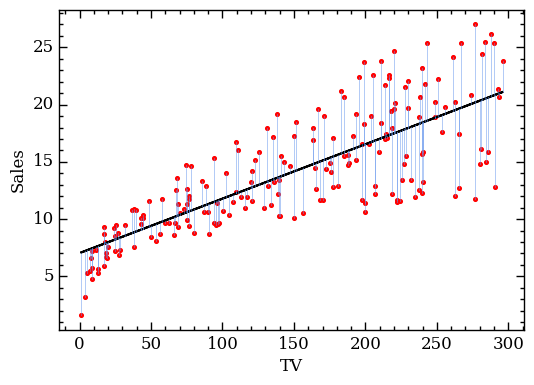

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(advertising.TV, advertising.Sales, color='r', s=7)
ax.plot(advertising['TV'], Sales_pred, color='k')
for x,y1,y2 in zip(advertising.TV, advertising.Sales, Sales_pred):
    ax.plot([x,x],[y1,y2], alpha=0.5, color='cornflowerblue', lw=0.7)
ax.set_xlabel('TV')
ax.set_ylabel('Sales')
plt.show()

In [12]:
scaler = preprocessing.StandardScaler(with_std=False)
Xtrain = scaler.fit_transform(advertising[['TV']])
#Xtrain = advertising[['TV']].values
linreg = linear_model.LinearRegression()
linreg.fit(Xtrain, advertising.Sales)
xz = Xtrain.ravel()
y = advertising.Sales
rss = sum((y - linreg.predict(Xtrain))**2)

# Creating grid of parameters
x0 = np.linspace(linreg.intercept_ - 2., linreg.intercept_ + 2., 50)
x1 = np.linspace(linreg.coef_[0] - 0.02, linreg.coef_[0] + 0.02, 50)
x0arr, x1arr = np.meshgrid(x0, x1, indexing='xy')
Z = np.zeros((x0.size,x1.size))
for (i,j),_ in np.ndenumerate(Z):
    coef1 = x0arr[i,j]
    coef2 = x1arr[i,j]
    Z[i,j] = sum((y - (coef1 + coef2*xz))**2)

Text(0.5,0,u'RSS')

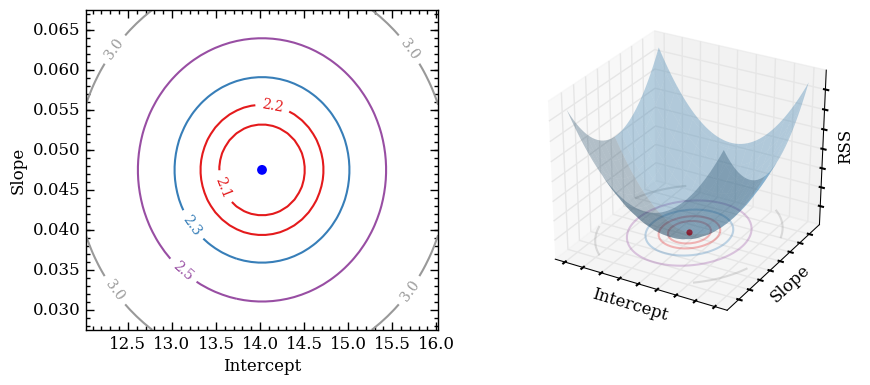

In [13]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
CS1 = ax1.contour(x0arr, x1arr, Z/float(1e3), cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3.0])
ax1.clabel(CS1, inline=True, fontsize=10, fmt='%1.1f')
ax1.scatter([linreg.intercept_],[linreg.coef_[0]], s=50)
ax1.set_ylabel(r'Slope')
ax1.set_xlabel(r'Intercept')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x0arr, x1arr, Z/1.e3, rstride=3, cstride=3, alpha=0.3)
ax2.tick_params(labelsize=1, rotation=60, labelbottom=False, labelleft=False)
ax2.scatter3D(linreg.intercept_, linreg.coef_[0], rss/1e3, c='r', label="RSS")
ax2.contour(x0arr, x1arr, Z/float(1e3), zdir='z', offset=(Z/1e3).min(), alpha=0.3, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3.0])

ax2.set_xlabel(r'Intercept', labelpad=-10)
ax2.set_ylabel(r'Slope', labelpad=-10)
ax2.set_zlabel('RSS', rotation=90, labelpad=-10)
#ax.xaxis.labelpad = 20


In [18]:
# Table 3.1
linreg.fit(advertising[['TV']], advertising.Sales)
result_linreg = ModelStat(linreg, advertising[['TV']], advertising.Sales)
result_linreg.results

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,7.032594,0.457843,15.360275,0.0,6.129719,7.935468
TV,0.047537,0.002691,17.667626,0.0,0.042231,0.052843


In [20]:
#Table 3.2
p = 1
n = len(advertising)
print('RSE : {0:12.5f}'.format((result_linreg.RSS/((len(advertising) - 2)))**0.5))
print('Rsquared : {0:7.5f}'.format(result_linreg.rsquare))
print('F-statistics : {0:7.5f}'.format(((result_linreg.TSS - result_linreg.RSS)/result_linreg.RSS)* ((n-p-1)/float(p))))

RSE :      3.25866
Rsquared : 0.61188
F-statistics : 312.14499


In [21]:
# Table 3.3
linreg.fit(advertising[['Radio']], advertising.Sales)
result_linreg = ModelStat(linreg, advertising[['Radio']], advertising.Sales)
display(result_linreg.results)
print('Simple regression of Sales on Radio')

linreg.fit(advertising[['Newspaper']], advertising.Sales)
result_linreg = ModelStat(linreg, advertising[['Newspaper']], advertising.Sales)
display(result_linreg.results)
print('Simple regression of Sales on Newspaper')


,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,9.311638,0.562900,16.542245,0.0,8.201588,10.421688
Radio,0.202496,0.020411,9.920765,0.0,0.162244,0.242747


Simple regression of Sales on Radio


,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,12.351407,0.621420,19.876096,0.000000,11.125956,13.576859
Newspaper,0.054693,0.016576,3.299591,0.001147,0.022005,0.087381


Simple regression of Sales on Newspaper


In [22]:
#Table 3.4
linreg.fit(advertising[['TV','Radio', 'Newspaper']], advertising.Sales)
result_linreg = ModelStat(linreg, advertising[['TV','Radio', 'Newspaper']], advertising.Sales)
display(result_linreg.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,2.938889,0.311908,9.422288,0.000000,2.323762,3.554016
TV,0.045765,0.001395,32.808624,0.000000,0.043014,0.048516
Radio,0.188530,0.008611,21.893496,0.000000,0.171547,0.205513
Newspaper,-0.001037,0.005871,-0.176715,0.859914,-0.012616,0.010541


In [23]:
# Table 3.5
advertising[['TV','Radio', 'Newspaper','Sales']].corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


In [24]:
#Table 3.6
p = 3
n = len(advertising)
print('RSE : {0:12.5f}'.format((result_linreg.RSS/((len(advertising) - 2)))**0.5))
print('Rsquared : {0:7.5f}'.format(result_linreg.rsquare))
print('F-statistics : {0:7.5f}'.format(((result_linreg.TSS - result_linreg.RSS)/result_linreg.RSS)* ((n-p-1)/float(p))))

RSE :      1.67698
Rsquared : 0.89721
F-statistics : 570.27070


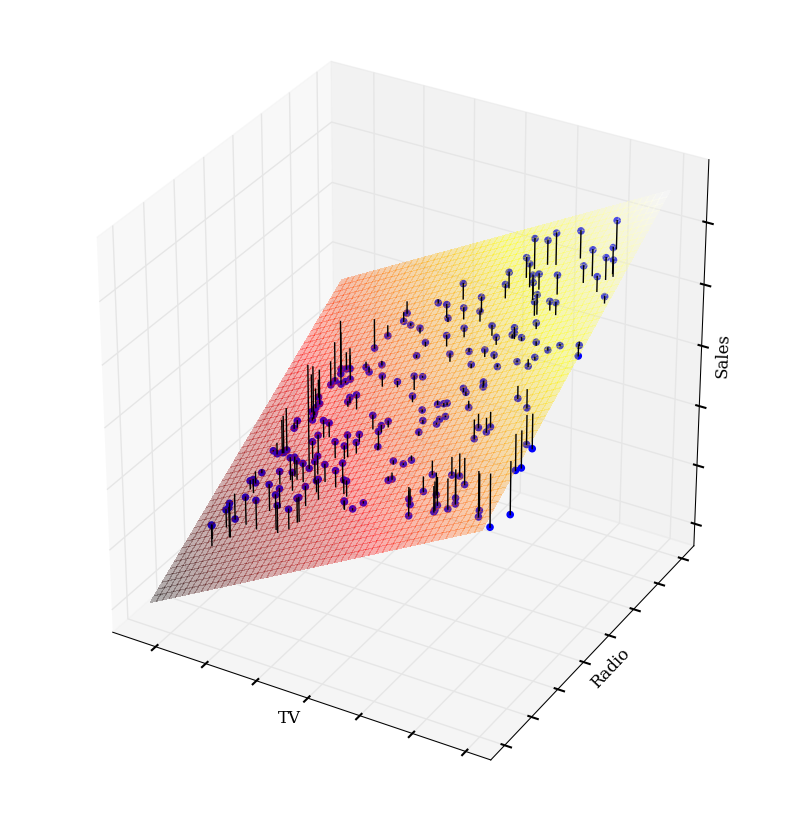

In [25]:
# Figure 3.5
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
xx = advertising[['TV','Radio']].values
linreg.fit(advertising[['TV','Radio']], advertising.Sales)
zz = linreg.predict(advertising[['TV','Radio']])

x1_arr=np.linspace(-20, 300,50)                # generate a mesh
x2_arr=np.linspace(-10, 60,50)
x1_surf, x2_surf = np.meshgrid(x1_arr, x2_arr)
Z = np.zeros((x1_arr.size,x2_arr.size))
for (i,j),_ in np.ndenumerate(Z):
    coeff1 = x1_surf[i,j]
    coeff2 = x2_surf[i,j]
    Z[i,j] = linreg.predict([[coeff1,coeff2]])

ax.scatter3D(xx[:,0], xx[:,1], advertising.Sales.values, color='b', alpha=1)
ax.plot_surface(x1_surf, x2_surf, Z, alpha=0.3, rstride=1, cstride=1, cmap=plt.cm.hot, shade=True,
                   linewidth=0, antialiased=False)
#ax.plot_surface(x1_surf, x2_surf, Z, alpha=0.6, cmap=plt.cm.rainbow, rstride=3, cstride=3)
ax.tick_params(labelsize=1, rotation=60, labelbottom=False, labelleft=False)
ax.set_xlabel(r'TV', labelpad=-10)
ax.set_ylabel(r'Radio', labelpad=-10)
ax.set_zlabel('Sales', rotation=90, labelpad=-10)
for x1,x2,y1,y2 in zip(xx[:,0], xx[:,1], advertising.Sales.values, zz):
    ax.plot3D([x1,x1],[x2,x2],[y1,y2], alpha=1.0, color='k', lw=1.0)


In [26]:
# Four: Prediction
linreg.fit(advertising[['TV','Radio']], advertising.Sales)
result_linreg = ModelStat(linreg, advertising[['TV','Radio']], advertising.Sales)
display(result_linreg.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,2.921100,0.29449,9.919193,0.0,2.340343,3.501857
TV,0.045755,0.00139,32.908708,0.0,0.043013,0.048497
Radio,0.187994,0.00804,23.382446,0.0,0.172139,0.203850


### Confidence interval
Uncertainty surrounding the average sales over a large number of cities

In [27]:
linreg.fit(advertising[['TV','Radio']], advertising.Sales)
result_linreg = ModelStat(linreg, advertising[['TV','Radio']], advertising.Sales)
newX = np.asarray([[100.0, 20.0]])
result_linreg.confidence_band(newX.reshape(-1,2), cols=['TV','Radio'])

,TV,Radio,fit,conf_lwr,conf_upr
0,100.0,20.0,11.256466,10.985254,11.527677


We interpret this to mean that 95% of intervals of this form will contain 
the true value of `f(X)`. In other words, if we collect a large number of data sets 
like the Advertising data set, and we construct a confidence interval for the 
average sales on the basis of each data set (given \$100,000 in `TV` and \$20,000 
in `radio` advertising), then 95% of these confidence intervals will contain the true value of average sales.

### Prediction interval
Uncertainty surrounding sales for a particular city

In [28]:
linreg.fit(advertising[['TV','Radio']], advertising.Sales)
result_linreg = ModelStat(linreg, advertising[['TV','Radio']], advertising.Sales)
newX = np.asarray([[100.0, 20.0]])
result_linreg.prediction_band(newX.reshape(-1,2), cols=['TV','Radio'])

,TV,Radio,fit,pred_lwr,pred_upr
0,100.0,20.0,11.256466,7.929616,14.583316


We interpret this to mean that 95% of intervals of this form will contain the true value of Y for this city

# Other Considerations in the Regression Model
## Qualitative Predictors

In [29]:
# Load Credit data
Credit = pd.read_csv('/Users/ando/andry/ML/courses/Statistics/Intro_to_Stat_learning/data/Credit.csv', index_col=[0])
# map categorical variable
Credit['genderI']= Credit['Gender'].map({' Male':0, 'Female':1})
Creditdf = pd.get_dummies(Credit, columns=['Ethnicity'], drop_first=True)

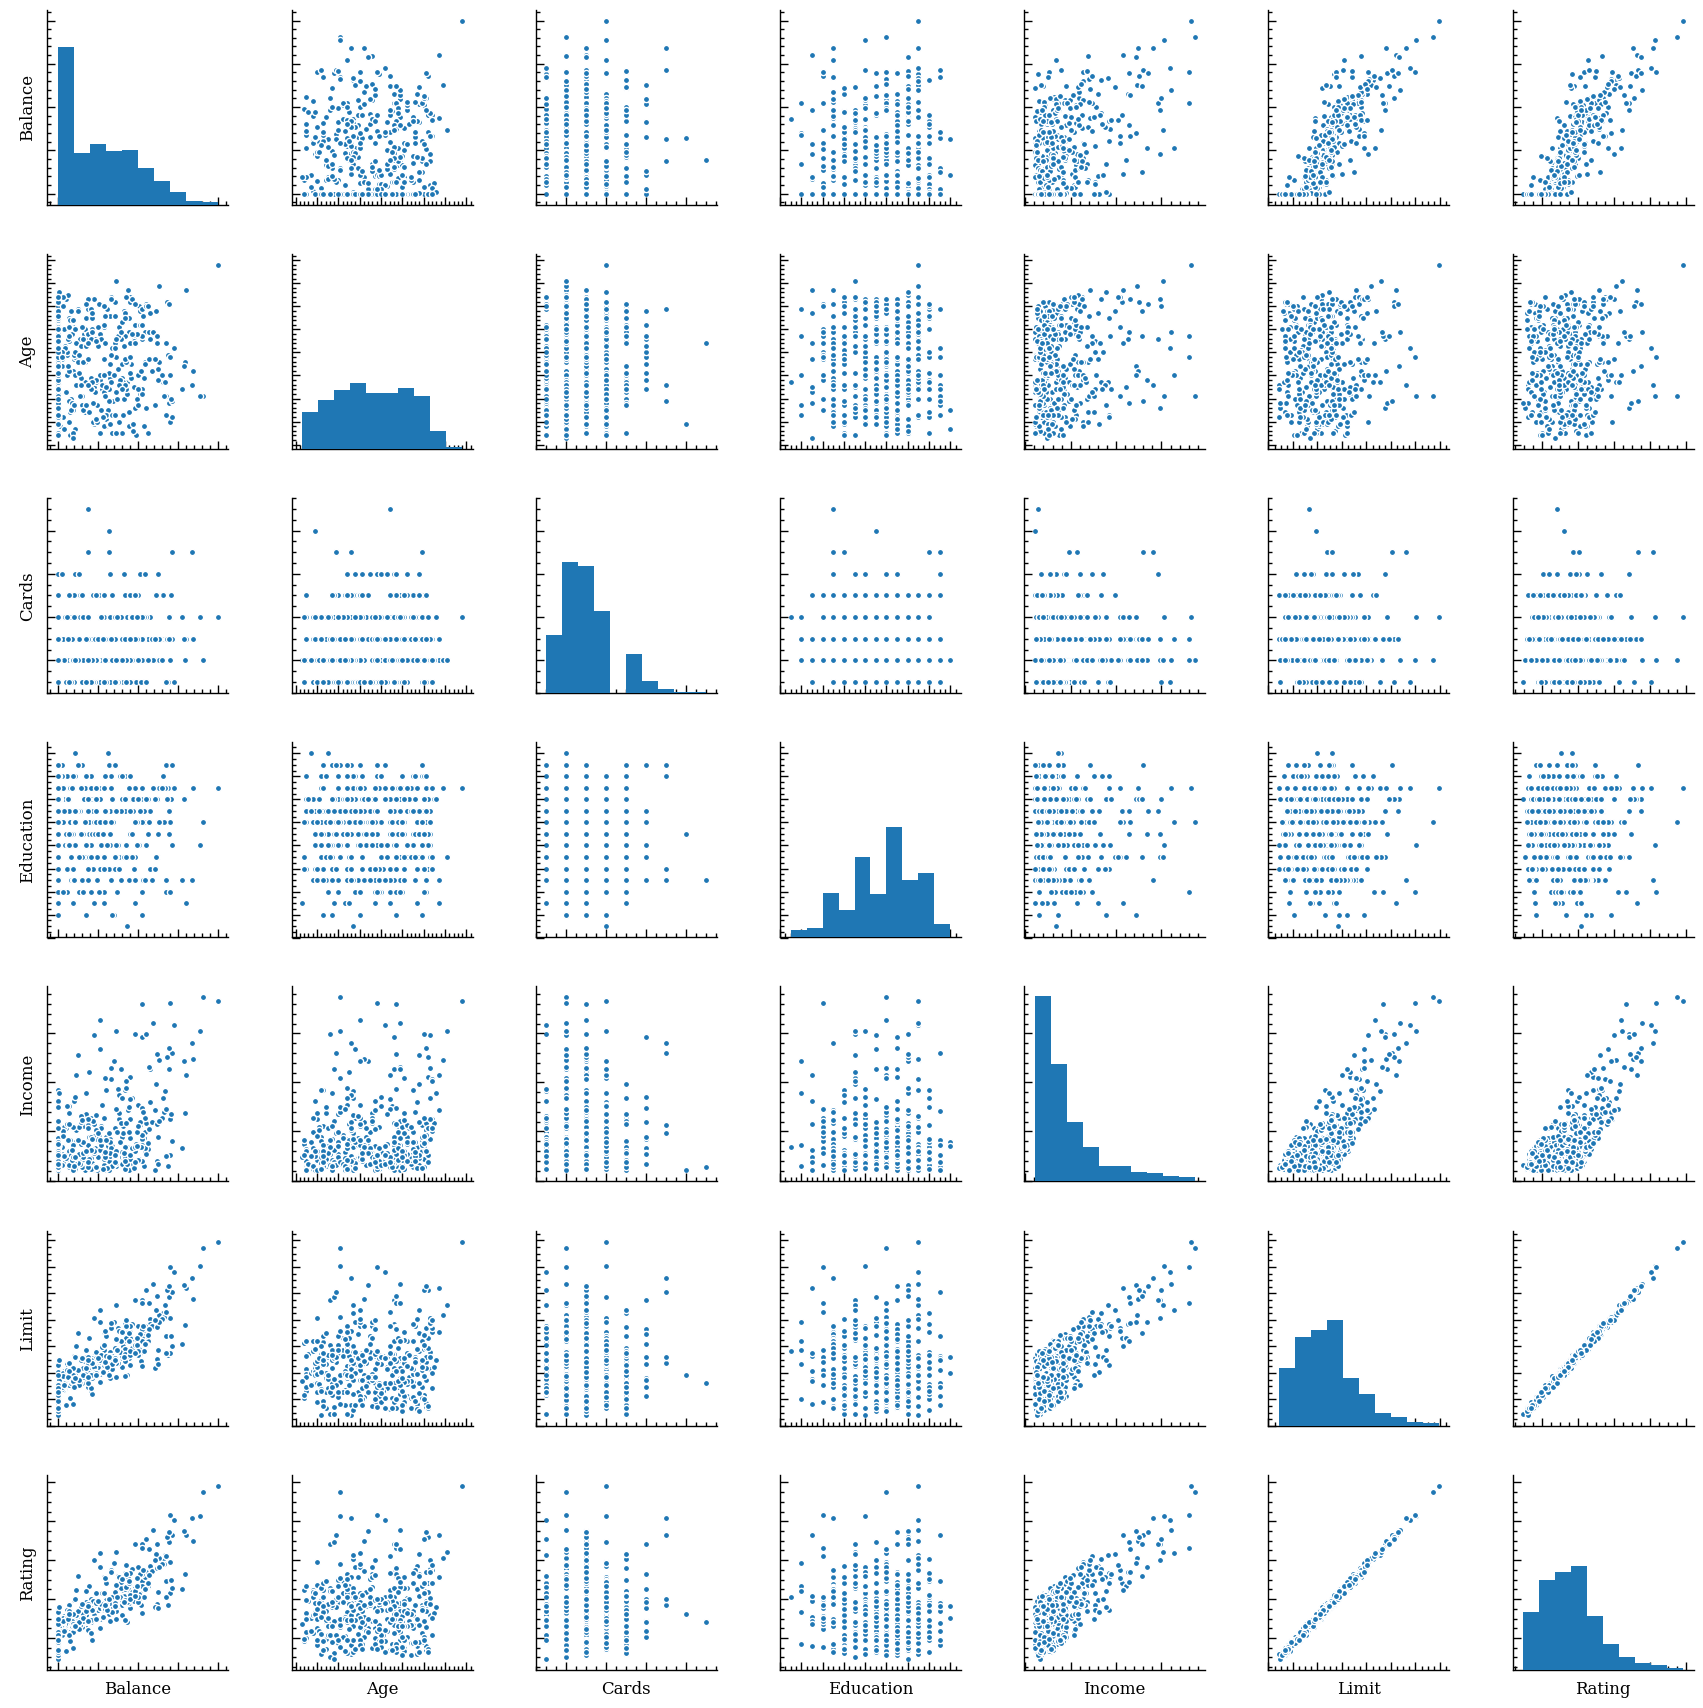

In [30]:
# figure 3.6
g = sns.pairplot(Credit[['Balance','Age','Cards','Education','Income','Limit','Rating']])
g.set(xticklabels=[], yticklabels=[])
plt.show()

### Predictor with only two levels

In [31]:
# Table 3.7
linreg = linear_model.LinearRegression()
var_linreg = ModelStat(linreg, Credit[['genderI']], Credit.Balance,fit=True)
display(var_linreg.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,509.803109,33.128077,15.388853,0.000000,444.675221,574.930997
genderI,19.733123,46.051210,0.428504,0.668516,-70.800900,110.267146


### Qualitative Predictors with More than Two Levels

In [32]:
# African American is baseline
ethnos = Creditdf[['Ethnicity_Asian', 'Ethnicity_Caucasian']]

# Table 3.8
linreg = linear_model.LinearRegression()
var_linreg = ModelStat(linreg, ethnos, Credit.Balance,fit=True)
display(var_linreg.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,531.000000,46.318683,11.464057,0.000000,439.939441,622.060559
Ethnicity_Asian,-18.686275,65.021075,-0.287388,0.773965,-146.514940,109.142391
Ethnicity_Caucasian,-12.502513,56.681038,-0.220577,0.825535,-123.935021,98.929995


## Extensions of the Linear Model

### Removing the Additive Assumption

In [33]:
# Create interacting variables TV * Radio
interact_df = advertising[['TV', 'Radio']].copy()
interact_df['TVxRadio'] = interact_df['TV']*interact_df['Radio']

# Table 3.9
linreg = linear_model.LinearRegression()
var_linreg = ModelStat(linreg, interact_df, advertising.Sales,fit=True)
print('\nRsquared : {0:7.5f}'.format(var_linreg.rsquare))
display(var_linreg.results)


Rsquared : 0.96779


,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,6.750220,0.247871,27.232755,0.000000,6.261383,7.239058
TV,0.019101,0.001504,12.698953,0.000000,0.016135,0.022067
Radio,0.028860,0.008905,3.240815,0.001399,0.011298,0.046423
TVxRadio,0.001086,0.000052,20.726564,0.000000,0.000983,0.001190


### Quantitative + qualitative variable

In [34]:
# Balance ~ Income + Student
Creditdf = Credit[['Income', 'Student']]
Creditdf = pd.get_dummies(Creditdf, columns=['Student'], drop_first=True)
linreg = linear_model.LinearRegression()
linreg.fit(Creditdf, Credit['Balance'])
ypred = linreg.predict(Creditdf)

# interacting variable
# Balance ~ Income + Student + Income*Student

Creditdf['IncomexStudent'] = Creditdf['Income']*Creditdf['Student_Yes']
linreg.fit(Creditdf, Credit['Balance'])
ypred1 = linreg.predict(Creditdf)

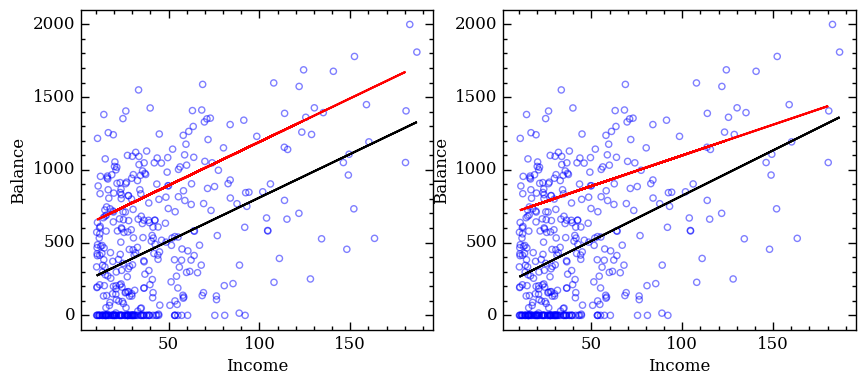

In [35]:
# Figure 3.7
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.scatter(Credit['Income'], Credit['Balance'], facecolors='None', edgecolors='b', alpha=0.5)
student = Credit.Student == 'Yes'
ax1.plot(Credit.loc[student,['Income']], ypred[student.values], color='r')
ax1.plot(Credit.loc[student == False,'Income'], ypred[student.values == False], color='k')

ax2.scatter(Credit['Income'], Credit['Balance'], facecolors='None', edgecolors='b', alpha=0.5)
ax2.plot(Credit.loc[student,['Income']], ypred1[student.values], color='r')
ax2.plot(Credit.loc[student == False,'Income'], ypred1[student.values == False], color='k')

for axs in (ax1,ax2):
    axs.set_xlabel('Income')
    axs.set_ylabel('Balance')
plt.show()

## Non-linear Relationship

In [36]:
# Load auto data
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()

In [37]:
# Table 3.10
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
Xpoly = poly.fit_transform(auto[['horsepower']])
linreg = linear_model.LinearRegression()
var_linreg = ModelStat(linreg, Xpoly, auto.mpg, fit=True,cols=['Intercept','horsepower','horsepower2'])
display(var_linreg.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,56.900100,1.800427,31.603673,0.0,53.360315,60.439885
horsepower,-0.466190,0.031125,-14.978164,0.0,-0.527383,-0.404996
horsepower2,0.001231,0.000122,10.080093,0.0,0.000991,0.001471


In [38]:
# Polynomial features
# linear
reg1 = linear_model.LinearRegression()
reg1.fit(auto[['horsepower']], auto.mpg)
ypred1 = reg1.predict(auto[['horsepower']])

# Quadratic
reg2 = linear_model.LinearRegression()
reg2.fit(Xpoly, auto.mpg)
ypred2 = reg2.predict(Xpoly)

# Fifth order polynomial
poly = preprocessing.PolynomialFeatures(degree=5, include_bias=False)
Xpoly5 = poly.fit_transform(auto[['horsepower']])
reg3 = linear_model.LinearRegression()
reg3.fit(Xpoly5, auto.mpg)
ypred5 = reg3.predict(Xpoly5)

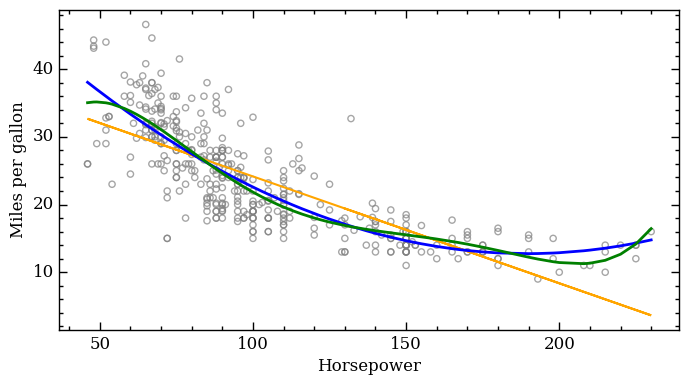

In [39]:
# Figure 3.8
fig, ax = plt.subplots(ncols=1, figsize=(8,4))
ax.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='grey', alpha=0.7)
ax.plot(auto.horsepower, ypred1, color='orange')
xs, ys = zip(*sorted(zip(auto.horsepower, ypred2)))
ax.plot(xs,ys, color='blue', lw=2)
xs, ys = zip(*sorted(zip(auto.horsepower, ypred5)))
ax.plot(xs,ys, color='green', lw=2)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Miles per gallon')
plt.show()

### Non-linearity of the Data

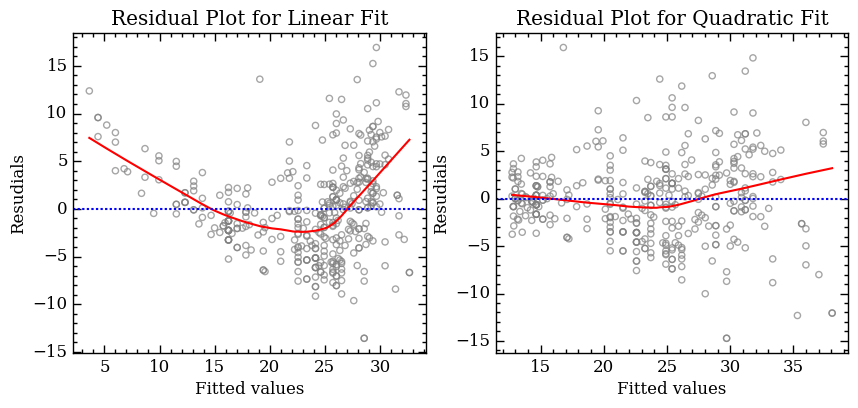

In [40]:
# Figure 3.9
ympg = auto.mpg.copy() 
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
res1 = ympg - ypred1
res2 = ympg - ypred2
ax1.scatter(ypred1, res1, facecolors='None', edgecolors='grey', alpha=0.7)
ax2.scatter(ypred2, res2, facecolors='None', edgecolors='grey', alpha=0.7)
lowess = sm.nonparametric.lowess
z = lowess(res1, ypred1)
ax1.plot(z[:,0], z[:,1], color='red')
z = lowess(res2, ypred2)
ax2.plot(z[:,0], z[:,1], color='red')

ax1.axhline(y=0.0, color='b', linestyle=':')
ax2.axhline(y=0.0, color='b', linestyle=':')
ax1.set_title('Residual Plot for Linear Fit')
ax2.set_title('Residual Plot for Quadratic Fit')
for axs in (ax1,ax2):
    axs.set_xlabel('Fitted values')
    axs.set_ylabel('Resudials')
plt.show()

### Outliers

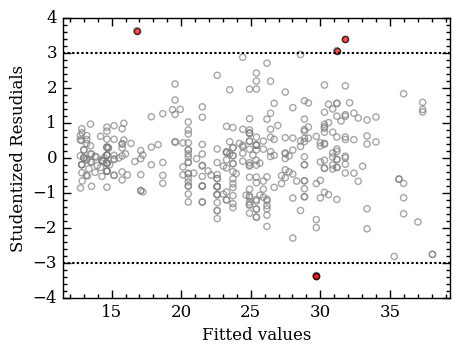

In [41]:
# ploting Studentized residual. Checking for outliers
linreg = linear_model.LinearRegression() 
var_linreg = ModelStat(linreg, Xpoly, auto.mpg, fit=True,cols=['Intercept','horsepower','horsepower2'])
fig, ax = plt.subplots(figsize=(5,3.5))
ypred2 = var_linreg.model.predict(Xpoly)
ystud = (ympg - ypred2)/np.sqrt(var_linreg.MSE)
ax.scatter(ypred2, ystud, facecolors='None', edgecolors='grey', alpha=0.7)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Studentized Resudials')
ax.axhline(y=3, color='k',linestyle=':')
ax.axhline(y=-3, color='k',linestyle=':')
ax.set_ylim(-4,4)
outlier = np.abs(ystud) > 3
ax.scatter(ypred2[outlier.values], ystud[outlier.values], facecolors='red', edgecolors='k', alpha=0.7)
plt.show()

### high leverage points

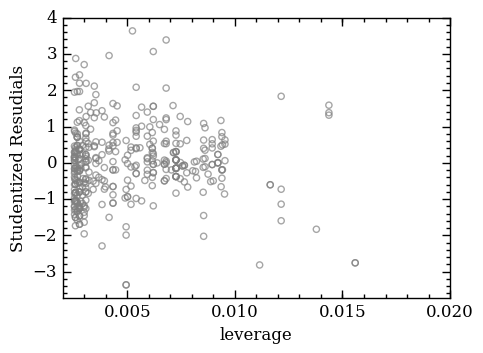

In [42]:
# leverage statistics
def leverage(X):
    n_obs = len(X)
    xmean = X.mean()
    sum_Xresid_square = ((X - xmean)**2).sum()
    hi = (1/float(n_obs)) + (((X-xmean)**2)/sum_Xresid_square)
    return hi

high_leverage = leverage(ypred2)
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(high_leverage, ystud, facecolors='None', edgecolors='grey', alpha=0.7)
ax.set_xlabel('leverage')
ax.set_ylabel('Studentized Resudials')
ax.set_xlim(0.002,0.02)
ax.xaxis.set_major_locator(MaxNLocator(4))
plt.show()

### Collinearity

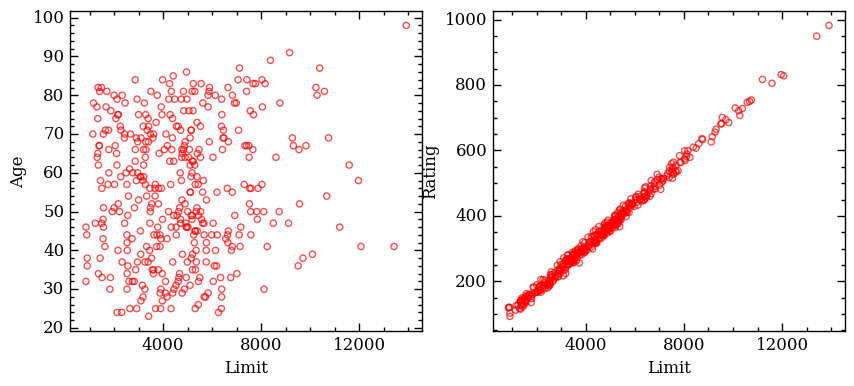

In [43]:
# Figure 3.14
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.scatter(Credit.Limit, Credit.Age, facecolors='None', edgecolors='red', alpha=0.7)
ax2.scatter(Credit.Limit, Credit.Rating, facecolors='None', edgecolors='red', alpha=0.7)
ax1.set_xlabel('Limit')
ax1.set_ylabel('Age')
ax2.set_xlabel('Limit')
ax2.set_ylabel('Rating')
ax1.xaxis.set_major_locator(MaxNLocator(4))
ax2.xaxis.set_major_locator(MaxNLocator(4))
plt.show()

In [44]:
y = Credit['Balance']
scaler = preprocessing.StandardScaler(with_std=False)
XL = scaler.fit_transform(Credit[['Limit','Age']])
reg1 = linear_model.LinearRegression()
reg1.fit(XL, y)

scaler = preprocessing.StandardScaler(with_std=False)
XR = scaler.fit_transform(Credit[['Limit','Rating']])
reg2 = linear_model.LinearRegression()
reg2.fit(XR, y)

X1,Y1,Z1 = grid_create(reg1, XL, y, 0.02, 3, ngrid=100)
X2,Y2,Z2 = grid_create(reg2, XR, y, 0.2, 3, ngrid=100)


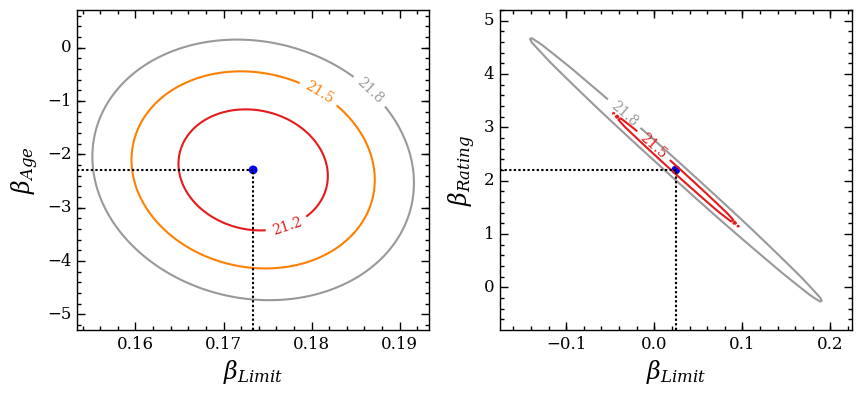

In [45]:
# Figure 3.15
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
CS1 = ax1.contour(X1, Y1, Z1/float(1000000), cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.clabel(CS1, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)
CS2 = ax2.contour(X2, Y2, Z2/float(1000000), cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax2.clabel(CS2, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
for axs,regs in zip([ax1,ax2],[reg1, reg2]): 
    axs.plot([regs.coef_[0],regs.coef_[0]],[axs.get_ylim()[0], regs.coef_[1]], ls=":", color='k')
    axs.plot([axs.get_xlim()[0],regs.coef_[0]],[regs.coef_[1], regs.coef_[1]], ls=":", color='k')
    axs.scatter(regs.coef_[0],regs.coef_[1], s=40)
    axs.xaxis.set_major_locator(MaxNLocator(4))
    axs.set_xlabel(r'$\beta_{Limit}$', fontsize=17)    
plt.show()

In [46]:
# Table 3.11
var_linreg = ModelStat(reg1, XL, y, fit=False,cols=['Intercept','Limit','Age'])
display(var_linreg.results)
var_linreg = ModelStat(reg2, XR, y, fit=False,cols=['Intercept','Limit','Rating'])
display(var_linreg.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,520.015000,11.526606,45.114319,0.000000,497.354183,542.675817
Limit,0.173365,0.005026,34.495944,0.000000,0.163485,0.183245
Age,-2.291486,0.672485,-3.407492,0.000722,-3.613562,-0.969410


,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,520.015000,11.616013,44.767082,0.000000,497.178413,542.851587
Limit,0.024514,0.063835,0.384030,0.701161,-0.100982,0.150010
Rating,2.201672,0.952294,2.311967,0.021289,0.329503,4.073841


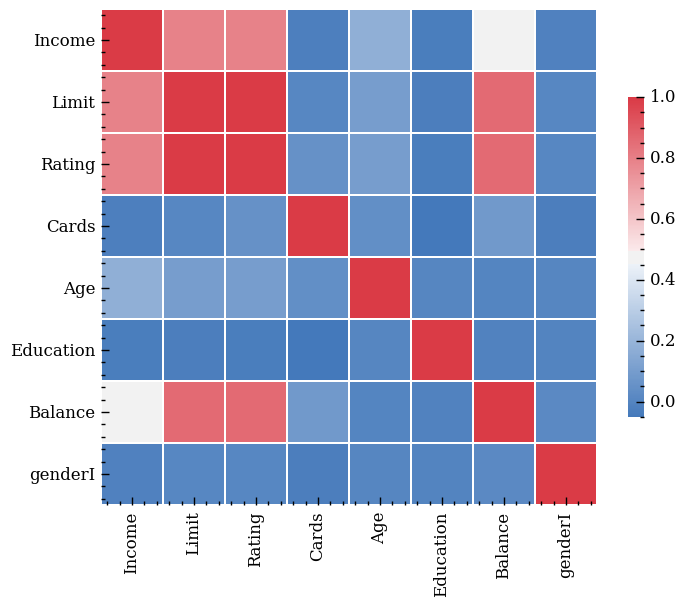

In [47]:
#Correlation matrix of the predictors to detect collinearity.
corr = Credit.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            cmap=cmap, square=True, linewidth=.5, 
            cbar_kws={"shrink": .5}, ax=ax)

### Variance inflation factor VIF
Detect multi-collinearity

In [48]:
#Writing a function to calculate the VIF values
def calc_vif(model, X, X_idx):
    """
    Check for colinearity.  Variance inflation factor VIF
    """
    y = X.iloc[:, X_idx]
    mm = X.columns[X_idx]
    X = X.drop(mm, axis=1)
    model.fit(X, y)
    ypred = model.predict(X)
    rankM = np.linalg.matrix_rank(X.values)
    dof = len(X) - rankM -1
    RSS = sum_square(y, ypred)
    TSS = sum_square(y, y.mean())
    MSE = RSS/float(dof)
    rsquare = 1.0 - (RSS/TSS)
    return 1.0/(1.0 - rsquare)
def sum_square(y,ypred):
    """
    Sum of square error
    """
    return sum((y-ypred)**2) 

def calculate_vif(X, thresh=5.0):
    """
    drop variables with high collinearity 
    """
    # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
    dropped=True
    linreg = linear_model.LinearRegression()
    while dropped:
        variables = X.columns
        dropped = False
        vif = [calc_vif(linreg, X[variables], X.columns.get_loc(var)) for var in X.columns]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print('Dropping "{}" with vif={}'.format(X.columns[maxloc], max_vif))
            X = X.drop([X.columns.tolist()[maxloc]], axis=1)
            dropped=True
    return X

In [51]:
columns = ['Limit','Age','Rating']
newCredit = calculate_vif(Credit[columns])

Dropping "Rating" with vif=160.668300959


In [52]:
linreg = linear_model.LinearRegression()
columns = ['Limit','Age','Rating']
vif_arr = []
for i, xvar in enumerate(columns):
    vif = calc_vif(linreg, Credit[columns], i)
    vif_arr.append([xvar, vif])
    
vif_arr

[['Limit', 160.59287978597655],
 ['Age', 1.0113846860681321],
 ['Rating', 160.66830095856935]]

In [53]:
# First solution: drop one of the problematic variables from the regression.
columns = ['Limit','Age']
vif_arr = []
for i, xvar in enumerate(columns):
    vif = calc_vif(linreg, Credit[columns], i)
    vif_arr.append([xvar, vif])
vif_arr

[['Limit', 1.0102830373035856], ['Age', 1.0102830373035872]]

In [54]:
# Second solution: Combine the collinear variables together into a single predictor.
scaler = preprocessing.StandardScaler()
limit_scale = scaler.fit_transform(Credit[['Limit']].values)
rating_scale = scaler.fit_transform(Credit[['Rating']].values)
Credit['Age_scale'] = scaler.fit_transform(Credit[['Age']].values)
credit_worthiness = (limit_scale + rating_scale)/2.0
Credit['credit_worthiness'] = credit_worthiness
var_linreg = ModelStat(linreg, Credit[['credit_worthiness', 'Age_scale']], Credit['Balance'], fit=True)
display(var_linreg.results)

/Users/ando/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,520.015000,11.456410,45.390747,0.000000,497.492186,542.537814
credit_worthiness,400.831866,11.525596,34.777541,0.000000,378.173036,423.490697
Age_scale,-40.052799,11.516601,-3.477832,0.000561,-62.693947,-17.411651


## Comparison of Linear Regression with K-Nearest Neighbors
### Parametric methods
* **advantages**:
    * easy to fit, because one need estimate only a small number of coefficients.
    * simple interpretations, and tests of statistical significance can be easily performed (case of Linear Regression)
* **disadvantage**:
    * make strong assumptions about the form of f(X). If the model is far from the truth, and prediction accuracy is our goal, then the parametric method will perform poorly.

==> *The parametric approach will outperform the nonparametric approach if the parametric form that has been selected is close to the true form of f.*

If relationship is linear, using non-parametric model incurs a cost in variance that is not offset by a reduction in bias.

As a general rule, **parametric methods** will tend to outperform **non-parametric** approaches when there is a small number of observations per predictor [Curse of dimensionality]. A given observation has no *nearby neighbors* That is, K observations that are nearest to a given test observation x0 may be mensionality very far away from x0 in p-dimensional space when p is large, leading to a very poor prediction of f(x0)

In [89]:
# fake data
x = np.linspace(-1, 1, 50)
y = 2.0 + x*2.0 + np.random.normal(0,0.4,size=len(x))
linreg = linear_model.LinearRegression()
linreg.fit(x.reshape(-1,1),y)
ypred = linreg.predict(x.reshape(-1,1))

from sklearn.neighbors import KNeighborsRegressor
# N_neighbor k = 1
neigh1 = KNeighborsRegressor(n_neighbors=1)
neigh1.fit(x.reshape(-1,1), y)
y_knn1 = neigh1.predict(x.reshape(-1,1))
# N_neighbor k = 9
neigh9 = KNeighborsRegressor(n_neighbors=9)
neigh9.fit(x.reshape(-1,1), y)
y_knn9 = neigh9.predict(x.reshape(-1,1)) 

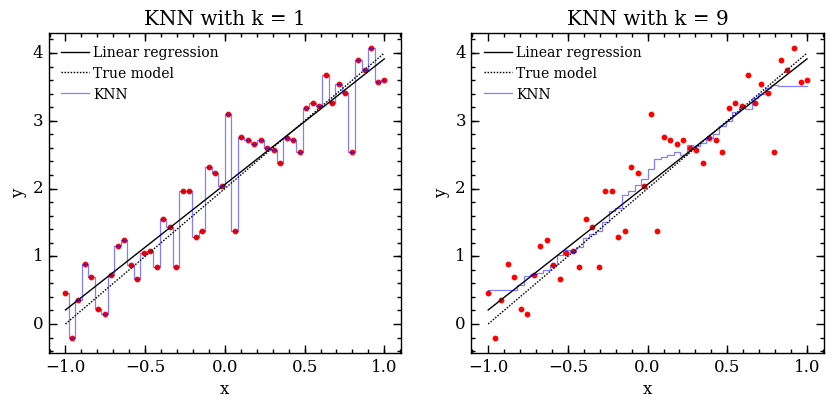

In [90]:
# Figure 3.17
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
for ax,yn in zip([ax1,ax2],[y_knn1, y_knn9]):
    ax.scatter(x,y, facecolors='r', s=10, edgecolors='r')
    ax.plot(x,ypred, label='Linear regression', color='k', lw=1.0)
    ax.plot(x, 2.0 + x*2.0, label='True model', color='k',ls=":", lw=1.0)
    ax.step(x, yn, where='mid', alpha=0.5, color='b', lw=0.9, label='KNN')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(prop={'size': 10})
ax1.set_title('KNN with k = 1')
ax2.set_title('KNN with k = 9')
plt.show()

In [91]:
# Figure 3.18
train, test = model_selection.train_test_split(np.arange(50), test_size=0.5, shuffle=True, random_state=1)

linreg = linear_model.LinearRegression()
linreg.fit(x[train].reshape(-1,1), y[train])
ypred_lin = linreg.predict(x[test].reshape(-1,1))
mse_lin = ModelStat.mean_squared_error(y[test],ypred_lin)

mse_knn = []
for i in range(9):
    neigh1 = KNeighborsRegressor(n_neighbors=i+1)
    neigh1.fit(x[train].reshape(-1,1), y[train])
    ypred = neigh1.predict(x[test].reshape(-1,1))
    mse_knn.append(ModelStat.mean_squared_error(y[test],ypred))

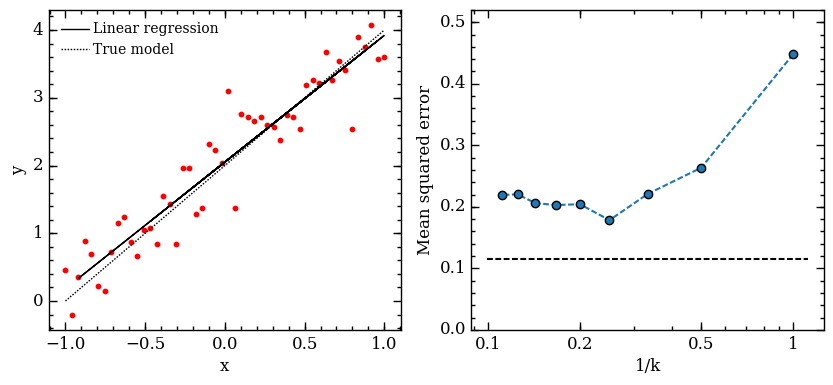

In [94]:
# Figure 3.17
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.scatter(x,y, facecolors='r', s=10, edgecolors='r')
ax1.plot(x[test],ypred_lin, label='Linear regression', color='k', lw=1.0)
ax1.plot(x, 2.0 + x*2.0, label='True model', color='k',ls=":", lw=1.0)
#ax1.step(x, yn, where='mid', alpha=0.5, color='b', lw=0.9, label='KNN')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(prop={'size': 10})
k = np.arange(9)+1.0
ax2.set_xscale('log')
ax2.set_ylim(0,0.52)
ax2.plot(1.0/k, mse_knn, 'o--')
ax2.plot(ax2.get_xlim(), [mse_lin, mse_lin], color='k', ls='--')
ax2.set_xlabel('1/k')
ax2.set_ylabel('Mean squared error')
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax2.xaxis.set_major_formatter(formatter)
ax2.set_xticks([0.1, 0.2, 0.5, 1.0])
plt.show()

In [95]:
linreg = linear_model.LinearRegression()
lin1 = ModelStat(linreg, Credit[['Limit']], Credit['Balance'], fit=True)
lin2 = ModelStat(linreg, Credit[['Limit', 'Age']], Credit['Balance'], fit=True)
lin3 = ModelStat(linreg, Credit[['Limit', 'Age', 'Education']], Credit['Balance'], fit=True)
anova_lm(lin1,lin2, lin3)

,dof,rss,dof_diff,rss_diff,F,Pr(>F)
0,398,2.171566e+07,0.0,NaN,NaN,NaN
1,397,2.109859e+07,1.0,617067.313870,11.589284,0.000731
2,396,2.108488e+07,1.0,13709.046946,0.257473,0.612144


# Lab: Linear Regression
## Simple Linear Regression

In [60]:
Boston = pd.read_table("Data/Boston.csv", sep=',')
Boston.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


In [61]:
linreg = linear_model.LinearRegression()
linreg_stat = ModelStat(linreg, Boston[['lstat']], Boston['medv'], fit=True)
display(linreg_stat.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,34.553841,0.562627,61.415146,0.0,33.448457,35.659225
lstat,-0.950049,0.038733,-24.527900,0.0,-1.026148,-0.873951


In [62]:
linreg = linear_model.LinearRegression()
linreg_stat = ModelStat(linreg, Boston[['lstat']], Boston['medv'], fit=True)

# Predict 'medv' with confidence and prediction intervals
newX = np.asarray([5.0,10.0,15.0])
conf_interval = linreg_stat.confidence_band(newX.reshape(-1,1))
pred_interval = linreg_stat.prediction_band(newX.reshape(-1,1))
display(conf_interval)
print('Confidence interval')
display(pred_interval)
print('Prediction interval')

,X0,fit,conf_lwr,conf_upr
0,5.0,29.803594,29.007412,30.599776
1,10.0,25.053347,24.474132,25.632563
2,15.0,20.303101,19.731588,20.874613


Confidence interval


,X0,fit,pred_lwr,pred_upr
0,5.0,29.803594,17.565675,42.041513
1,10.0,25.053347,12.827626,37.279068
2,15.0,20.303101,8.077742,32.528459


Prediction interval


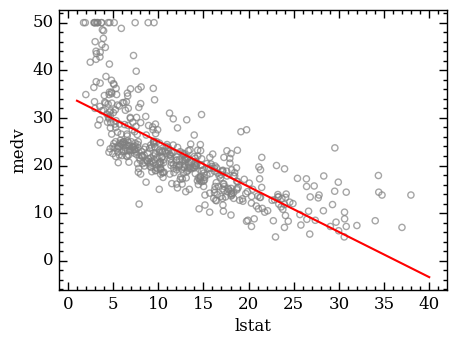

In [63]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(Boston.lstat, Boston.medv, facecolors='None', edgecolors='grey', alpha=0.7)
ax.set_xlabel('lstat')
ax.set_ylabel('medv')
newX = np.arange(40)+1
pred = linreg.predict(newX.reshape(-1,1))
ax.plot(newX, pred, color='red')
plt.show()

## Multiple Linear Regression

In [64]:
linreg = linear_model.LinearRegression()
linreg_stat = ModelStat(linreg, Boston[['lstat', 'age']], Boston['medv'], fit=True)
display(linreg_stat.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,33.222761,0.730847,45.457881,0.000000,31.786872,34.658650
lstat,-1.032069,0.048191,-21.416330,0.000000,-1.126748,-0.937389
age,0.034544,0.012225,2.825605,0.004906,0.010525,0.058564


In [65]:
# All predictors used
linreg = linear_model.LinearRegression()
linreg_stat = ModelStat(linreg, Boston.loc[:,Boston.columns !='medv'], Boston['medv'], fit=True)
display(linreg_stat.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,36.459488,5.103459,7.144074,3.275380e-12,26.432226,46.486751
crim,-0.108011,0.032865,-3.286517,1.086660e-03,-0.172584,-0.043438
zn,0.046420,0.013727,3.381576,7.779905e-04,0.019449,0.073392
indus,0.020559,0.061496,0.334310,7.382878e-01,-0.100268,0.141385
chas,2.686734,0.861580,3.118381,1.924811e-03,0.993904,4.379563
nox,-17.766611,3.819744,-4.651257,4.243532e-06,-25.271634,-10.261589
rm,3.809865,0.417925,9.116140,0.000000e+00,2.988727,4.631004
age,0.000692,0.013210,0.052402,9.582293e-01,-0.025262,0.026647
dis,-1.475567,0.199455,-7.398004,5.997425e-13,-1.867455,-1.083679
rad,0.306049,0.066346,4.612900,5.068084e-06,0.175692,0.436407


In [66]:
# Variance inflation factor check
linreg = linear_model.LinearRegression()
columns = list(Boston.columns[Boston.columns !='medv'].values)
vif_arr = []
for i, xvar in enumerate(columns):
    vif = calc_vif(linreg, Boston[columns], i)
    vif_arr.append([xvar, vif])
    
vif_arr

[['crim', 1.7921915474332413],
 ['zn', 2.2987581787494191],
 ['indus', 3.991596418346028],
 ['chas', 1.0739953275538012],
 ['nox', 4.3937198475775077],
 ['rm', 1.9337444357832554],
 ['age', 3.1008255128153435],
 ['dis', 3.955944906372725],
 ['rad', 7.4844963352744847],
 ['tax', 9.0085539475970968],
 ['ptratio', 1.79908404924891],
 ['black', 1.3485210764063749],
 ['lstat', 2.9414910780919334]]

## Interaction Terms

In [67]:
Boston_interact = Boston[['lstat','age']].copy()
Boston_interact['lstatxage'] = Boston.lstat * Boston.age
linreg_stat = ModelStat(linreg, Boston_interact, Boston['medv'], fit=True)
display(linreg_stat.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,36.088536,1.469835,24.552773,0.000000e+00,33.200749,38.976323
lstat,-1.392117,0.167456,-8.313352,8.881784e-16,-1.721117,-1.063117
age,-0.000721,0.019879,-0.036262,9.710878e-01,-0.039777,0.038336
lstatxage,0.004156,0.001852,2.244283,2.524824e-02,0.000518,0.007794


## Non-linear Transformation of the Predictors

In [68]:
poly = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(Boston[['lstat']])
# this will add an array of 1s
Nonlin_stat = ModelStat(linreg, X_poly[:,1:], Boston['medv'], fit=True, cols=['Intercept','lstat','lstat**2'])
display(Nonlin_stat.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,42.862007,0.872084,49.148921,0.0,41.148631,44.575384
lstat,-2.332821,0.123803,-18.842963,0.0,-2.576056,-2.089586
lstat**2,0.043547,0.003745,11.627546,0.0,0.036189,0.050905


**ANOVA** : Analyse of variance to further quantify the extent to  which the quadratic fit is superior to the linear fit.

**Null Hypothesis**: the two models fit the data equally well
**Alternative Hypothesis**: the non-linear model is superior.

**Result**: p-value very small 7.6e-28 so we reject the null hypothesis. The Non-linear model is far superior.


In [69]:
linreg_stat = ModelStat(linreg, Boston[['lstat']], Boston['medv'], fit=True)
anova_lm(linreg_stat, Nonlin_stat)

,dof,rss,dof_diff,rss_diff,F,Pr(>F)
0,504,19472.381418,0.0,NaN,NaN,NaN
1,503,15347.243158,1.0,4125.13826,135.199822,7.630116e-28


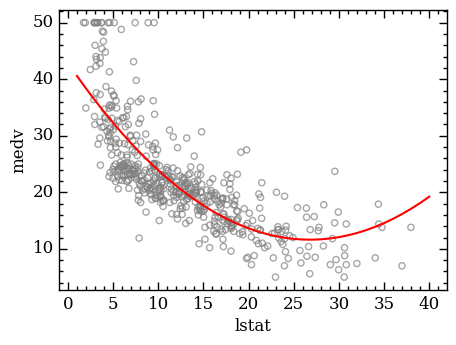

In [70]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(Boston.lstat, Boston.medv, facecolors='None', edgecolors='grey', alpha=0.7)
ax.set_xlabel('lstat')
ax.set_ylabel('medv')
newX = np.arange(40)+1
X_poly2 = poly.fit_transform(newX.reshape(-1,1))
Nonlin = linear_model.LinearRegression()
Nonlin.fit(X_poly[:,1:], Boston['medv'])
pred = Nonlin.predict(X_poly2[:,1:])
ax.plot(newX, pred, color='red')
plt.show()

In [71]:
# fifth-order polynomial
poly = preprocessing.PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly.fit_transform(Boston[['lstat']])
linreg = linear_model.LinearRegression(normalize=True)
Nonlin_stat5 = ModelStat(linreg, X_poly, Boston['medv'], fit=True, cols=['Intercept','lstat','lstat2','lstat3','lstat4','lstat5'])
display(Nonlin_stat5.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,67.699677,0.128239,527.916799,0.000000e+00,67.447723,67.951631
lstat,-11.991117,0.298080,-40.227848,0.000000e+00,-12.576760,-11.405473
lstat2,1.272818,0.077876,16.344123,0.000000e+00,1.119813,1.425823
lstat3,-0.068274,0.006601,-10.342249,0.000000e+00,-0.081244,-0.055304
lstat4,0.001726,0.000225,7.673606,8.792966e-14,0.001284,0.002168
lstat5,-0.000016,0.000003,-6.141081,1.670214e-09,-0.000022,-0.000011


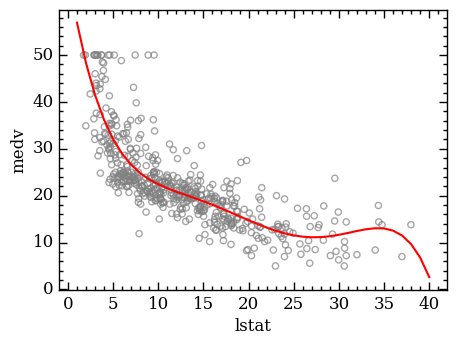

In [72]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(X_poly[:,0], Boston.medv.values, facecolors='None', edgecolors='grey', alpha=0.7)
ax.set_xlabel('lstat')
ax.set_ylabel('medv')
newX = np.arange(40)+1
X_poly5 = poly.fit_transform(newX.reshape(-1,1))
Nonlin = linear_model.LinearRegression()
Nonlin.fit(X_poly, Boston['medv'])
pred = Nonlin.predict(X_poly5)
ax.plot(newX, pred, color='red')
plt.show()

In [73]:
# Anova
anova_lm(linreg_stat, Nonlin_stat, Nonlin_stat5)

,dof,rss,dof_diff,rss_diff,F,Pr(>F)
0,504,19472.381418,0.0,NaN,NaN,NaN
1,503,15347.243158,1.0,4125.138260,151.692566,1.192917e-30
2,500,13597.035027,3.0,1750.208131,21.453306,4.371573e-13


## Qualitative predictor

In [74]:
Carseats = pd.read_csv("Data/Carseats.csv", index_col=0)
Carseats = pd.get_dummies(Carseats, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

In [75]:
# full model + interaction terms Income:Advertising and Price:Age 
Carseats['Income:Advertising'] = Carseats.Income * Carseats.Advertising
Carseats['Price:Age'] = Carseats.Price * Carseats.Age

In [76]:
columns = Carseats.columns[Carseats.columns != 'Sales']
linreg = linear_model.LinearRegression(normalize=True)
model_stat = ModelStat(linreg, Carseats[columns], Carseats.Sales, fit=True, cols=['Intercept','lstat','lstat2','lstat3','lstat4','lstat5'])
display(model_stat.results)

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
Intercept,6.575565,1.008747,6.518548,2.217502e-10,4.592239,8.558892
CompPrice,0.092937,0.004118,22.566822,0.000000e+00,0.084840,0.101034
Income,0.010894,0.002604,4.182842,3.564610e-05,0.005773,0.016015
Advertising,0.070246,0.022609,3.106985,2.029527e-03,0.025794,0.114699
Population,0.000159,0.000368,0.432899,6.653290e-01,-0.000564,0.000883
Price,-0.100806,0.007440,-13.549437,0.000000e+00,-0.115434,-0.086179
Age,-0.057947,0.015951,-3.632883,3.180340e-04,-0.089307,-0.026586
Education,-0.020852,0.019613,-1.063189,2.883591e-01,-0.059414,0.017709
ShelveLoc_Good,4.848676,0.152838,31.724319,0.000000e+00,4.548177,5.149175
ShelveLoc_Medium,1.953262,0.125768,15.530652,0.000000e+00,1.705986,2.200538
